In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
import numpy as np
from Allineamento import *
from datetime import datetime

In [2]:
def projectDistZ(x1,x2,y1,y2,d12,z):
    mx = (x2-x1)/d12
    xProj = x1 + mx * z
    
    my = (y2-y1)/d12
    yProj = y1 + my * z
    
    return (xProj, yProj)

def get_theta_angles(x1, y1, x2, y2, d):
    import numpy as np
    thetaX = np.arctan((x2-x1)/d) #rad
    thetaY = np.arctan((y2-y1)/d) #rad
    return (thetaX, thetaY)


def file_loader(runs):
    """
    Load the data file for a given run number.
    """
    from collections.abc import Iterable
    
    if not isinstance(runs, Iterable):
        runs = [runs]

    pos = []
    infos = []
    phs = []
    tmis = []
    evis =[]
    nclus = []
    info_pluss =[]
    bases = []
    for run_number in runs:
        data_path =f'data/TB_T9_2025/run{run_number}.h5'
        print('\nopening ', data_path)
        pos = []
        phs = []
        tmis =[]
        qtots =[]
        nclus = []
        info_pluss =[]
        xinfos =[]
        with h5py.File(data_path, 'r', libver='latest', swmr=True) as hf:
            # print(hf.keys())
            hf["xpos"].shape
            keys = list(hf.keys())
            pos.append(np.array(hf['xpos']))
            phs.append(np.array(hf['digiPH'])) # from 24
            tmis.append(np.array(hf['digiTime'])) # from 24
            qtots.append(np.array(hf['qtot'])) # from 24
            nclus.append(np.array(hf['nclu'])) # from 24
            info_pluss.append(np.array(hf['info_plus']))
            xinfos.append(np.array(hf['xinfo']))
            #for k in hf.keys():
            #    comand = f'{k} = np.array(hf["{k}"])'
                # print(comand)
            #  exec(comand)
            # print(len(pos))
    xpos = np.concatenate(pos,axis=0)
    ph = np.concatenate(phs,axis=0)
    tm = np.concatenate(tmis,axis=0)
    qtot = np.concatenate(qtots,axis=0)
    nclu = np.concatenate(nclus,axis=0)
    info_plus = np.concatenate(info_pluss,axis=0)
    xinfo = np.concatenate(xinfos,axis=0)
    # print('xpos shape', xpos.shape)
    
    # print(np.unique(xinfo[:,1]))
        # print('xpos shape', xpos.shape)

    xpos[:,2]= xpos[:,2] - offset_x2 
    xpos[:,3]= xpos[:,3] - offset_y2 
    
    x1 = xpos[:,0]
    y1 = xpos[:,1]
    x2 = xpos[:,2] 
    y2 = xpos[:,3] 
    x3 = xpos[:,4]
    y3 = xpos[:,5]


    Calibration = False
    if Calibration:
        q = -25.84
        m = 323.4
        ph[:,2]=  (ph[:,2] - q)/m

    xcry, ycry = projectDistZ(x1,x2,y1,y2,d12,d1c)
    theta_x_in, theta_y_in = get_theta_angles(x1, y1, x2, y2, d12)
    theta_x_out, theta_y_out = get_theta_angles(xcry, ycry, x3, y3, dc3)


    ph_calo_photon = ph[:,2]
    ph_cherry1 = ph[:,0]
    print(f'{runs} -- N spill: {info_plus[:,0][-1]} -- events: {len(ph_calo_photon)} -- evs/spill: {len(ph_calo_photon)/info_plus[:,0][-1]:.0f}')
    return xpos, x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
    theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus,xinfo


In [3]:
d12 = 330 ## cm
d23 = 66.8
d1c = 330 + 53.2 #cm
dc3 = 10.7 
d1calo = d1c + 779.2 

offset_x2 =   -0.19494474108211143
offset_y2 =   2.276578722633391 

range_chamber = ((0,10),(0,10))
bins2d = (100,100)
mycmap = 'jet'

opt_hist = {'histtype': 'step', 'lw': 1.5, 'alpha': 0.8}
opts_2d = { "cmap" : mycmap, "bins" : bins2d} # "norm" : mpl.colors.LogNorm()}

th_cherry1 = 20
th_cherry2 = 20


# Define scan numbers

In [4]:
# scan_number = [730230,730223,730224,730227,730228,730229,730231,730241,730242,730244]
scan_number = [730245,730224]


opening  data/TB_T9_2025/run730245.h5


OSError: Unable to open file (truncated file: eof = 3830420, sblock->base_addr = 0, stored_eof = 3856761)

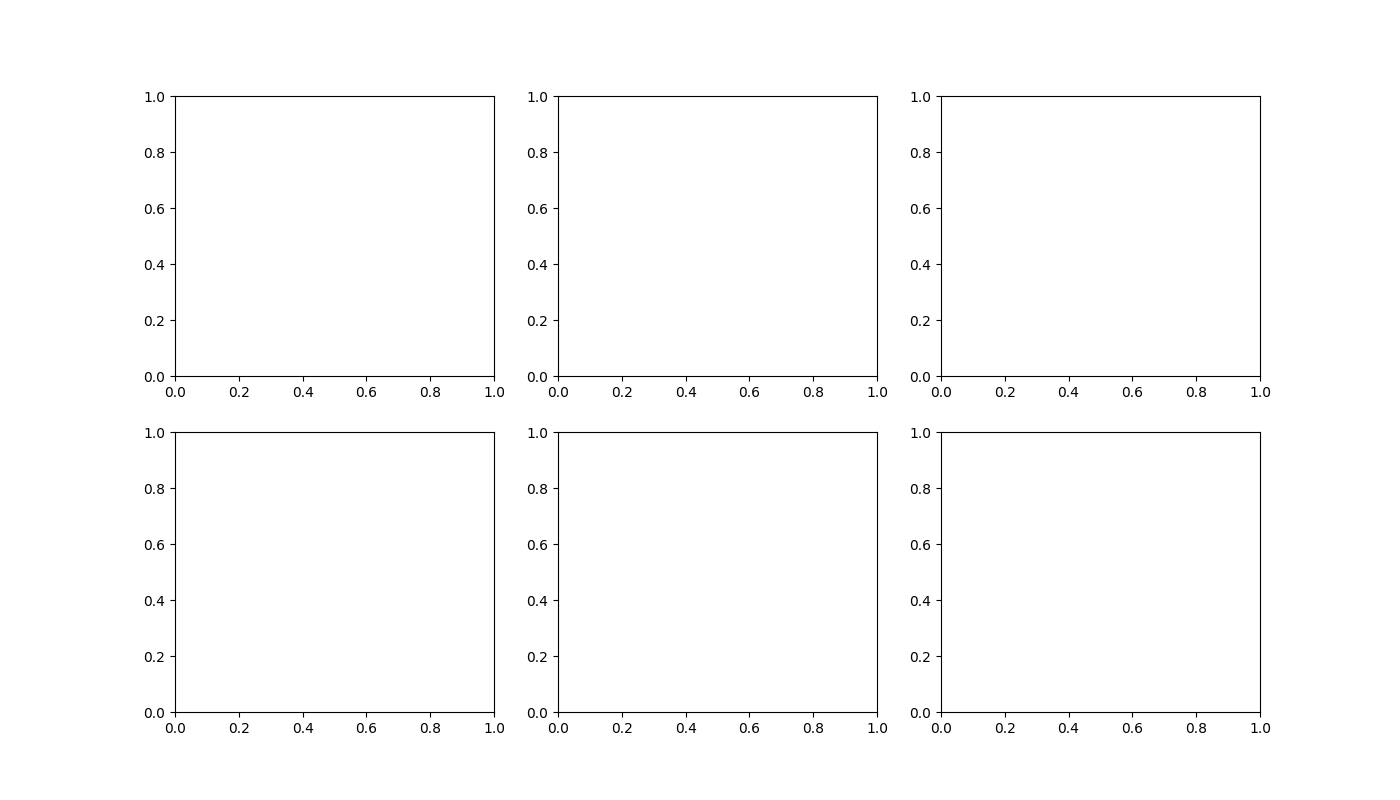

In [5]:
x_cry_cut = [4.6, 4.9]
y_cry_cut = [4.7, 5.15]
if any(run in scan_number for run in [730223, 730224, 730227, 730225, 730228, 730229, 730230,730231,730241,730242,730243,730244,730245]):
    x_cry_cut = [4.6, 4.9]
    y_cry_cut = [4.7, 5.15]

isrot = False
iscrad = True
opt_hist = dict(histtype='step', linewidth=1.5)

fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharey=False)
axs = axs.flatten()  # Makes indexing easier (axs[0] to axs[5])

for run in scan_number:
    xpos, x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
    theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus, xinfo = file_loader(run)

    if iscrad:
        scan_angle = xinfo[:, 1]
    else:
        scan_angle = xinfo[:, 0]

    unique_steps = np.unique(scan_angle)
    print(f'unique step values {unique_steps}')
    n_steps = len(unique_steps)

    for i, step in enumerate(unique_steps):
        logi = (ph_cherry1 > th_cherry1) & \
               (scan_angle == step) & \
               (xcry > x_cry_cut[0]) & (xcry < x_cry_cut[1]) & \
               (ycry > y_cry_cut[0]) & (ycry < y_cry_cut[1])

        if np.sum(logi) == 0:
            continue

        axs[0].hist(ph_calo_photon[logi], bins=20, range=(0, 3000), label=f'Step {step:.0f} -- {np.mean(ph_calo_photon[logi]):.2f}', density=True, **opt_hist)
        axs[1].hist(qtot[:, 0][logi], bins=50, range=(0, 5000), label=f'Step {step:.0f} -- {np.mean(qtot[:, 0][logi]):.2f}', density=True, **opt_hist)
        axs[2].hist(nclu[:, 0][logi], bins=50, label=f'Step {step:.0f} -- {np.mean(nclu[:, 0][logi]):.2f}', density=True, **opt_hist)
        axs[3].hist(x3[logi], bins=20,range = (4,6), label=f'Step {step:.0f}', density=True, **opt_hist)
        axs[4].hist(y3[logi], bins=20,range = (4,6), label=f'Step {step:.0f}', density=True, **opt_hist)

# Titoli
axs[0].set_title(f'scan: {scan_number[0]}–{scan_number[-1]}\nCalo Photon PH')
axs[1].set_title('qtot[0]')
axs[2].set_title('nclu[0]')
axs[3].set_title('x3')
axs[4].set_title('y3')

# Assi e scala log
labels = ['Calo PH [ADC]', 'qtot[0] [ADC]', 'nclu[0]', 'x3 [mm]', 'y3 [mm]']
for j in range(3):
    axs[j].set_xlabel(labels[j])
    axs[j].set_ylabel('Counts')
    axs[j].set_yscale('log')
    axs[j].legend()  # enable if needed

plt.tight_layout()
plt.show()



opening  data/TB_T9_2025/run730245.h5
[730245] -- N spill: 284 -- events: 27166 -- evs/spill: 96

opening  data/TB_T9_2025/run730224.h5
[730224] -- N spill: 1334 -- events: 194507 -- evs/spill: 146


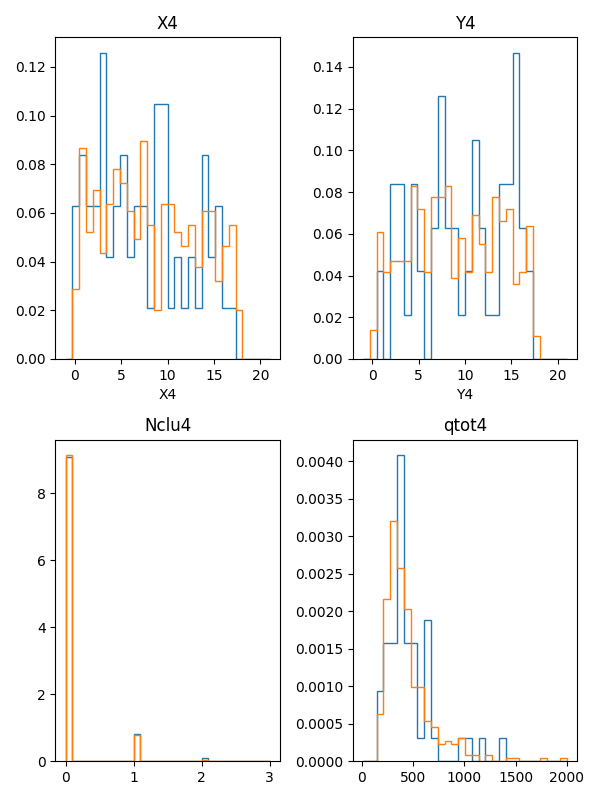

In [6]:
fig, ax = plt.subplots(2,2, figsize = (6,8))
iWantDensity = True
for run in scan_number:
    if run >730198:
        xpos, x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
        theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus, xinfo = file_loader(run)

        mask = (ph_cherry1 > th_cherry1) & \
           (xcry > x_cry_cut[0]) & (xcry < x_cry_cut[1]) & \
           (ycry > y_cry_cut[0]) & (ycry < y_cry_cut[1])
        ax = ax.flatten()
        x4 = xpos[:,6]
        y4 = xpos[:,7]


        ax[0].hist(x4[mask], bins = 30, range = (-1,21), histtype = 'step', density = iWantDensity)
        ax[0].set_title('X4')
        ax[0].set_xlabel('X4')
        ax[1].hist(y4[mask], bins = 30, range = (-1,21), histtype = 'step', density = iWantDensity)
        ax[1].set_title('Y4')
        ax[1].set_xlabel('Y4')

        ax[2].hist(nclu[:,2][mask], bins = 30, histtype = 'step', density = iWantDensity)
        # ax[2].hist(nclu[:,3][mask], bins = 30, histtype = 'step')
        ax[2].set_title('Nclu4')

        ax[3].hist(qtot[:,2][mask], bins = 30, range = (10,2000), histtype = 'step', density = iWantDensity)
        # ax[3].hist(qtot[:,3][mask], bins = 30, range = (10,2000), histtype = 'step')
        ax[3].set_title('qtot4')
        
        
plt.tight_layout()
plt.show()


opening  data/TB_T9_2025/run730245.h5
[730245] -- N spill: 122 -- events: 11837 -- evs/spill: 97

opening  data/TB_T9_2025/run730224.h5
[730224] -- N spill: 1334 -- events: 194507 -- evs/spill: 146


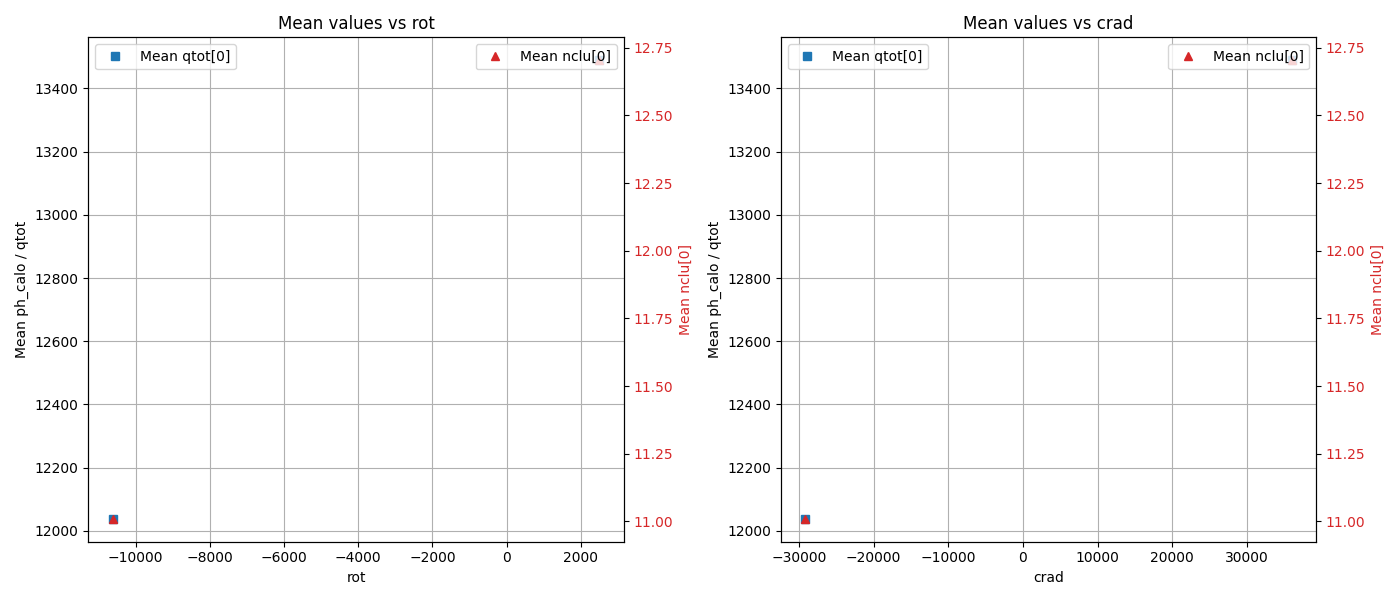

In [27]:
# Dizionari per accumulare dati per ogni valore unico
data_rot = {}
data_crad = {}

for run in scan_number:
    x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
    theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus, xinfo = file_loader(run)

    mask = (ph_cherry1 > th_cherry1) & \
           (xcry > x_cry_cut[0]) & (xcry < x_cry_cut[1]) & \
           (ycry > y_cry_cut[0]) & (ycry < y_cry_cut[1])

    # Accumulo per rot (xinfo[:,0])
    for r in np.unique(xinfo[:,0]):
        sel = mask & (xinfo[:,0] == r)
        if np.sum(sel) == 0:
            continue
        if r not in data_rot:
            data_rot[r] = {'ph': [], 'qtot': [], 'nclu': []}
        data_rot[r]['ph'].extend(ph_calo_photon[sel])
        data_rot[r]['qtot'].extend(qtot[:,0][sel])
        data_rot[r]['nclu'].extend(nclu[:,0][sel])

    # Accumulo per crad (xinfo[:,1])
    for c in np.unique(xinfo[:,1]):
        sel = mask & (xinfo[:,1] == c)
        if np.sum(sel) == 0:
            continue
        if c not in data_crad:
            data_crad[c] = {'ph': [], 'qtot': [], 'nclu': []}
        data_crad[c]['ph'].extend(ph_calo_photon[sel])
        data_crad[c]['qtot'].extend(qtot[:,0][sel])
        data_crad[c]['nclu'].extend(nclu[:,0][sel])

# Ora calcolo le medie
rot_vals = sorted(data_rot.keys())
mean_ph_rot = [np.mean(data_rot[r]['ph']) for r in rot_vals]
mean_qtot_rot = [np.mean(data_rot[r]['qtot']) for r in rot_vals]
mean_nclu_rot = [np.mean(data_rot[r]['nclu']) for r in rot_vals]

crad_vals = sorted(data_crad.keys())
mean_ph_crad = [np.mean(data_crad[c]['ph']) for c in crad_vals]
mean_qtot_crad = [np.mean(data_crad[c]['qtot']) for c in crad_vals]
mean_nclu_crad = [np.mean(data_crad[c]['nclu']) for c in crad_vals]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14,6), sharey=False)

# ROT plot
ax1 = axs[0]
# ax1.plot(rot_vals, mean_ph_rot, 'o', label='Mean ph_calo')
ax1.plot(rot_vals, mean_qtot_rot, 's', label='Mean qtot[0]')
ax1.set_xlabel('rot')
ax1.set_ylabel('Mean ph_calo / qtot')
ax1.set_title('Mean values vs rot')
ax1.grid(True)
ax1.legend(loc='upper left')

ax1b = ax1.twinx()
ax1b.plot(rot_vals, mean_nclu_rot, '^', color='tab:red', label='Mean nclu[0]')
ax1b.set_ylabel('Mean nclu[0]', color='tab:red')
ax1b.tick_params(axis='y', labelcolor='tab:red')
ax1b.legend(loc='upper right')

# CRAD plot
ax2 = axs[1]
# ax2.plot(crad_vals, mean_ph_crad, 'o', label='Mean ph_calo')
ax2.plot(crad_vals, mean_qtot_crad, 's', label='Mean qtot[0]')
ax2.set_xlabel('crad')
ax2.set_ylabel('Mean ph_calo / qtot')
ax2.set_title('Mean values vs crad')
ax2.grid(True)
ax2.legend(loc='upper left')

ax2b = ax2.twinx()
ax2b.plot(crad_vals, mean_nclu_crad, '^', color='tab:red', label='Mean nclu[0]')
ax2b.set_ylabel('Mean nclu[0]', color='tab:red')
ax2b.tick_params(axis='y', labelcolor='tab:red')
ax2b.legend(loc='upper right')

plt.tight_layout()
plt.show()


## Stereogramma

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Dizionari per accumulare dati (lista di valori) per coppie (rot, crad)
ph_calo_map = {}
qtot0_map = {}
nclu0_map = {}
sigma_x3_map = {}
sigma_y3_map = {}


for run in scan_number:
    x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
    theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus, xinfo = file_loader(run)

    rots = np.unique(xinfo[:, 0])
    crads = np.unique(xinfo[:, 1])

    for rot in rots:
        for crad in crads:
            logi = (ph_cherry1 > th_cherry1) & (xinfo[:, 0] == rot) & (xinfo[:, 1] == crad) & \
                   (xcry > x_cry_cut[0]) & (xcry < x_cry_cut[1]) & (ycry > y_cry_cut[0]) & (ycry < y_cry_cut[1])
            if np.sum(logi) == 0:
                continue

            ph = ph_calo_photon[logi]
            qt = qtot[:, 0][logi]
            nc = nclu[:, 0][logi]
            x3_sel = x3[logi]
            y3_sel = y3[logi]

            key = (rot, crad)
            if key not in ph_calo_map:
                ph_calo_map[key] = []
                qtot0_map[key] = []
                nclu0_map[key] = []
                sigma_x3_map[key] = []
                sigma_y3_map[key] = []

            ph_calo_map[key].extend(ph)
            qtot0_map[key].extend(qt)
            nclu0_map[key].extend(nc)
            sigma_x3_map[key].append(np.std(x3_sel))
            sigma_y3_map[key].append(np.std(y3_sel))

# Ora calcoliamo le medie per ogni (rot, crad)
# points = list(ph_calo_map.keys())

points = [p for p in ph_calo_map.keys() if p[1] <= 60000]

rots_vals = np.array([p[0] for p in points])
crads_vals = np.array([p[1] for p in points])

mean_ph_calo_vals = np.array([np.mean(ph_calo_map[p]) for p in points])
mean_qtot0_vals = np.array([np.mean(qtot0_map[p]) for p in points])
mean_nclu0_vals = np.array([np.mean(nclu0_map[p]) for p in points])
mean_sigma_x3_vals = np.array([np.mean(sigma_x3_map[p]) for p in points])
mean_sigma_y3_vals = np.array([np.mean(sigma_y3_map[p]) for p in points])

# Funzione per scatter plot con colorbar
def plot_scatter_heatmap_with_max_circle(x, y, z, title, xlabel='rot', ylabel='crad'):
    plt.figure(figsize=(8,6))
    sc = plt.scatter(x, y, c=z, cmap='jet', s=80, edgecolor='k')
    plt.colorbar(sc, label='Mean Value')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    
    # Trova indice del valore massimo di z
    max_idx = np.argmax(z)
    # Disegna un cerchio rosso attorno al punto con valore massimo
    plt.scatter(x[max_idx], y[max_idx], s=300, facecolors='none', edgecolors='r', linewidths=2)
    
    plt.tight_layout()
    plt.show()
def plot_scatter_heatmap_with_max_circle_and_arrow(x, y, z, title, xlabel='rot', ylabel='crad'):
    plt.figure(figsize=(8,6))
    sc = plt.scatter(x, y, c=z, cmap='jet', s=80, edgecolor='k')
    plt.colorbar(sc, label='Mean Value')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    
    # Punto massimo
    max_idx = np.argmax(z)
    plt.scatter(x[max_idx], y[max_idx], s=300, facecolors='none', edgecolors='r', linewidths=2)
    
    # Ultimo punto unico
    last_x = x[-1]
    last_y = y[-1]

    # Aggiungo freccia e testo per l'ultimo punto
    plt.annotate('Last point',
                 xy=(last_x, last_y), xycoords='data',
                 xytext=(last_x + 1000, last_y + 1000), textcoords='data',
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=10, color='black')
    
    plt.tight_layout()
    plt.show()


opening  data/TB_T9_2025/run730245.h5
[730245] -- N spill: 122 -- events: 11837 -- evs/spill: 97

opening  data/TB_T9_2025/run730224.h5
[730224] -- N spill: 1334 -- events: 194507 -- evs/spill: 146


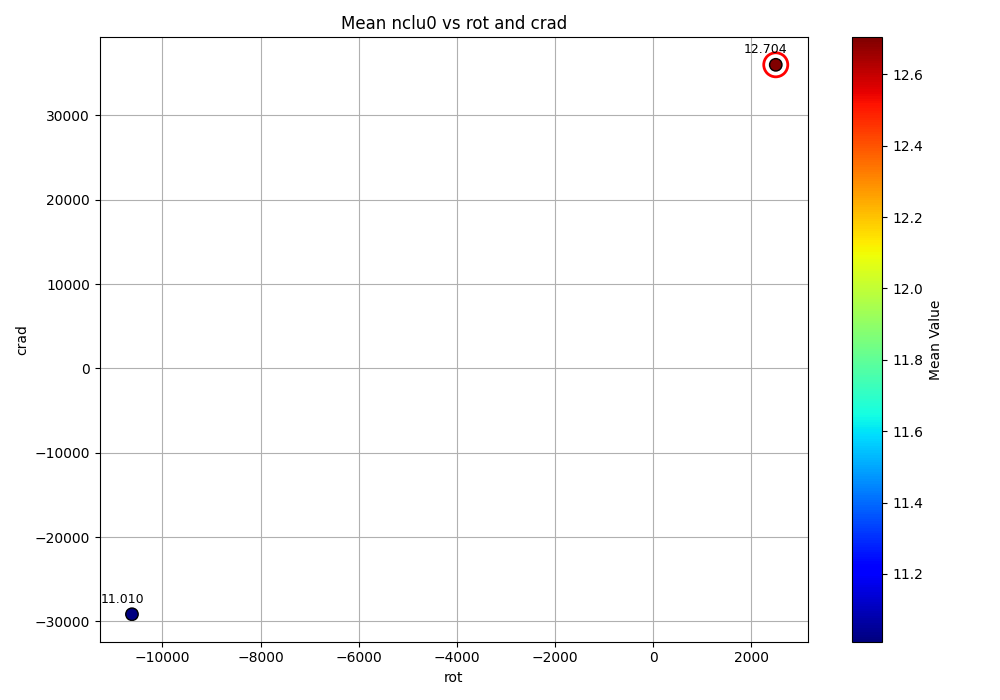

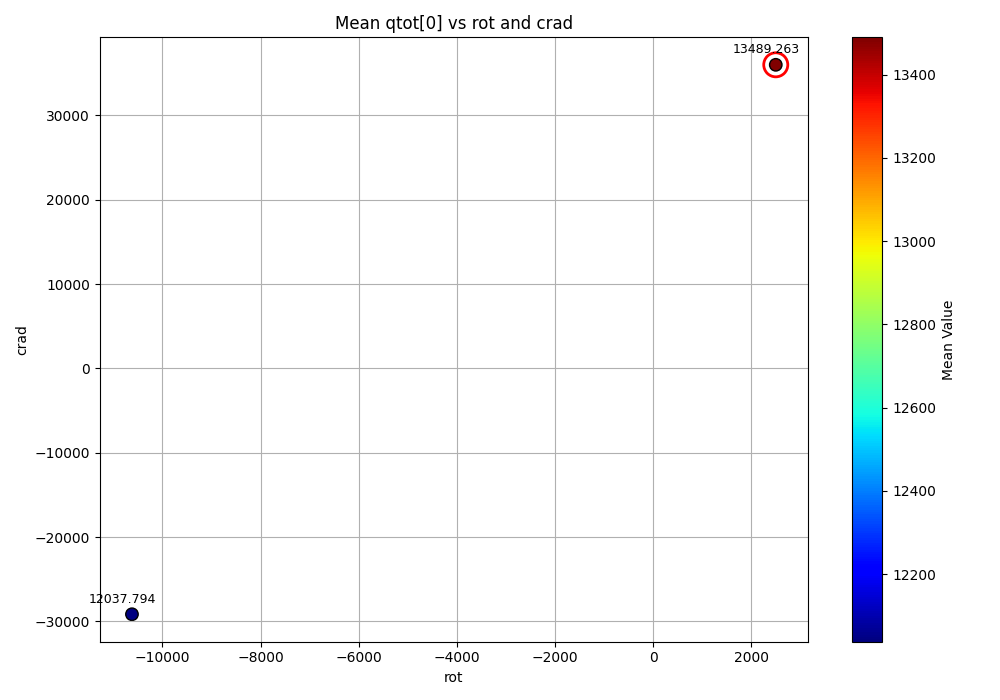

In [29]:
def plot_scatter_heatmap_with_max_circle_and_arrow_and_labels(x, y, z, title, xlabel='rot', ylabel='crad'):
    plt.figure(figsize=(10, 7))
    sc = plt.scatter(x, y, c=z, cmap='jet', s=80, edgecolor='k')
    cbar = plt.colorbar(sc, label='Mean Value')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)

    # Label numerica per ogni punto
    for xi, yi, zi in zip(x, y, z):
        plt.text(xi-200, yi + 1000, f'{zi:.3f}', ha='center', va='bottom', fontsize=9, color='black')

    # Punto con valore massimo
    max_idx = np.argmax(z)
    max_x = x[max_idx]
    max_y = y[max_idx]
    plt.scatter(max_x, max_y, s=300, facecolors='none', edgecolors='r', linewidths=2)

    # Ultimo punto
    last_x = x[-1]
    last_y = y[-1]
    # plt.annotate('Last point',
    #              xy=(last_x, last_y), xycoords='data',
    #              xytext=(last_x + 1000, last_y + 1000), textcoords='data',
    #              arrowprops=dict(facecolor='black', arrowstyle='->'),
    #              fontsize=10, color='black')

    plt.tight_layout()
    plt.show()

# plot_scatter_heatmap_with_max_circle_and_arrow_and_labels(rots_vals, crads_vals, mean_ph_calo_vals, 'Mean Calo Photon PH vs rot and crad')
plot_scatter_heatmap_with_max_circle_and_arrow_and_labels(rots_vals, crads_vals, mean_nclu0_vals, 'Mean nclu0 vs rot and crad')
plot_scatter_heatmap_with_max_circle_and_arrow_and_labels(rots_vals, crads_vals, mean_qtot0_vals, 'Mean qtot[0] vs rot and crad')

# plot_scatter_heatmap_with_max_circle_and_arrow_and_labels(rots_vals, crads_vals, mean_sigma_x3_vals, 'Sigma X3 vs rot and crad')
# plot_scatter_heatmap_with_max_circle_and_arrow_and_labels(rots_vals, crads_vals, mean_sigma_y3_vals, 'Sigma Y3 vs rot and crad')

